# TRABAJO PRACTICO INVOP
### Consigna 1: Licitación

#### 🏫 Generación de datos
- [X] Generar **709 escuelas** con coordenadas en un rectángulo predefinido.
- [X] Crear un conjunto de **empresas ficticias** (A, B, C, ...).
- [X] Generar **tres instancias distintas** de ofertas de las empresas para las escuelas.

#### 📊 Modelos de licitación
- [X] Implementar el **modelo básico de licitación**.
- [ ] Ejecutar el modelo para **cada una de las tres instancias**.
- [ ] Implementar y correr el **modelo alternativo** que detecta si hay **más de un óptimo**.

#### 🧩 Unidades de Competencia (UC)
- [ ] Verificar que en **alguna instancia haya más de una empresa ganadora** en una misma UC.
- [ ] Seleccionar esa UC y **aplicar el algoritmo greedy de asignación** de escuelas dentro de ella.

#### 🧪 Validación y visualización
- [X] Visualizar la **geolocalización de las escuelas** en el plano.
- [ ] Mostrar los **resultados de las licitaciones** y las **empresas ganadoras**.
- [ ] Analizar y comentar los **casos con múltiples óptimos**.


In [55]:
# SIGUIENTES PASOS
# EJECUTAR PARA LAS OTRAS 2 - hay que agregar que tmb busquen la segunda mejor sol
# ESCRIBIR INFORME
# poner lindo...


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pyscipopt import Model

np.random.seed(1902+209+703)

## Creamos las funciones

In [57]:
# Subproblema: Construir las clases de equivalencia - J_i y I_j

def son_equivalentes(i,j,B):
    return (B[i,:]==B[j,:]).all()
        

def extraer_clases_equivalencias(B):
    clases_equivalencias=[]
    sin_ofertantes=[]
    empresas_participantes=[]
    areas_donde_participan=[[] for i in range (B.shape[1])]
    for i in range(B.shape[0]):
        lo_meti=False
        #Separamos las escuelas sin ofertantes
        if (B[i,:]==np.zeros_like(B[i,:])).all():
            sin_ofertantes.append(i)
            lo_meti=True

        j=0 #Nos fijamos en las distintas clases de equivalencias que ya definimos si i pertenece a alguna clase de equivalencia ya definida
        
        while j<len(clases_equivalencias) and not lo_meti :
            representante=clases_equivalencias[j][0]
            if son_equivalentes(i,representante,B):
                clases_equivalencias[j].append(i)
                
                lo_meti=True
            j+=1
        if not lo_meti:
            clases_equivalencias.append([i])
            
            #J_i
            aux=[]
            for ind in range(B.shape[1]):
                if B[i,ind]==1:
                    aux.append(ind)
                    #se va computando mientras se crea clases de equivalencia
                    areas_donde_participan[ind].append(len(clases_equivalencias)-1)
            empresas_participantes.append(aux)
            
    return clases_equivalencias, sin_ofertantes, empresas_participantes, areas_donde_participan


In [58]:
# función que va a crear el modelo a minimizar
def definir_modelo(B,costos,nombre_modelo,T_max,T_min):
    model=Model(nombre_modelo)
    M=B.shape[0]
    num_empresas=B.shape[1]
    J, sin_ofertantes, I_j, J_i = extraer_clases_equivalencias(B)
    x=np.empty([num_empresas,len(J)],dtype="object")
    y=np.empty([num_empresas,len(T_max)],dtype="object")
    z=np.empty([num_empresas,len(T_max)],dtype="object")
    for i in range(num_empresas):
        for j in range(len(J)):
            #(11)
            x[i,j]=model.addVar(name=f"x_{i}_{j}",vtype="I")
            
        for t in range(len(T_max)):
            #(12)
            y[i,t]=model.addVar(name=f"y_{i}_{t}",vtype="B")
            #(13)
            z[i,t]= model.addVar(name=f"z_{i}_{t}",vtype="I")

    #(5)
    model.setObjective(sum(costos[i,t]*z[i,t] for i in range(num_empresas) for t in range(len(T_max))),"minimize")

    #(6)
    for j in range(len(J)):
        model.addCons(sum(x[i,j] for i in I_j[j]) ==len(J[j]))

    
    for i in range(num_empresas):
        #(9)
        model.addCons(sum(y[i,t] for t in range(len(T_max))) == 1)

        for t in range(len(T_max)):
            #(7)
            model.addCons(sum(x[i,j] for j in J_i[i]) >= T_min[t] - M*(1-y[i,t])) 
            #(8)
            model.addCons(sum(x[i,j] for j in J_i[i]) <= T_max[t] + M*(1-y[i,t]))
            #(10)
            model.addCons(sum(x[i,j] for j in J_i[i])-M*(1-y[i,t]) <= z[i,t])
    
    return model, sin_ofertantes, x

In [59]:
# definimos la funcion que calcula el segundo óptimo
def obtener_optimos_alternativos(B,costos,modelo_anterior,solucion_previa,T_max,T_min):
    model=Model()
    M=B.shape[0]
    num_empresas=B.shape[1]
    J, sin_ofertantes, I_j, J_i = extraer_clases_equivalencias(B)
    x=np.empty([num_empresas,len(J)],dtype="object")
    y=np.empty([num_empresas,len(T_max)],dtype="object")
    z=np.empty([num_empresas,len(T_max)],dtype="object")
    for i in range(num_empresas):
        for j in range(len(J)):
            #(11)
            x[i,j]=model.addVar(name=f"x_{i}_{j}",vtype="I")
            
        for t in range(len(T_max)):
            #(12)
            y[i,t]=model.addVar(name=f"y_{i}_{t}",vtype="B")
            #(13)
            z[i,t]= model.addVar(name=f"z_{i}_{t}",vtype="I")

    #(5)
    model.setObjective(sum(costos[i,t]*z[i,t] for i in range(num_empresas) for t in range(len(T_max))),"minimize")

    #(6)
    for j in range(len(J)):
        model.addCons(sum(x[i,j] for i in I_j[j]) ==len(J[j]))

    
    for i in range(num_empresas):
        #(9)
        model.addCons(sum(y[i,t] for t in range(len(T_max))) == 1)

        for t in range(len(T_max)):
            #(7)
            model.addCons(sum(x[i,j] for j in J_i[i]) >= T_min[t] - M*(1-y[i,t])) 
            #(8)
            model.addCons(sum(x[i,j] for j in J_i[i]) <= T_max[t] + M*(1-y[i,t]))
            #(10)
            model.addCons(sum(x[i,j] for j in J_i[i])-M*(1-y[i,t]) <= z[i,t])
    
   ##############################################################################################
    J_I_validos=[]
    a={}
    M=B.shape[0]
    for v in modelo_anterior.getVars():
        if v.name[0]=="x" and solucion_previa[v] != 0:
            aux=v.name.split("_") #separo los numeros [x,i,j]
            J_I_validos.append((int(aux[-1]),int(aux[1])))
            a[int(aux[-1]),int(aux[1])]=solucion_previa[v]        
    #Creamos almacenamiento de las nuevas variables
    w={}
    w_prima={}
    #añadimos las variables al modelo
    for j, i in J_I_validos:
        w[j,i]=model.addVar(name=f"w_{j}_{i}",vtype="B")
        w_prima[j,i]=model.addVar(name=f"w_prima_{j}_{i}",vtype="B")

    #añadimos las constrains para bloquear la solucion anterior
    for j,i in J_I_validos:

        model.addCons(x[i,j]>= (a[j,i]+1)*w[j,i])

        model.addCons(M - x[i,j] >= (M - (a[j,i] - 1)) * w_prima[j,i])

    model.addCons(sum(w[j,i]+w_prima[j,i] for j, i in J_I_validos)>=1)


    return model, sin_ofertantes

In [78]:
# para analizar la solución
def filtrar_variables_ganadores(model,solucion):
    reparto={}
    for v in model.getVars():
        if v.name[0]=="x" and solucion[v] != 0:
            aux=v.name.split("_") #separo los numeros [x,i,j]
            reparto[int(aux[1]),int(aux[-1])]=solucion[v]
    return reparto

In [79]:
#plotear distribución en una unidad de reparto
def plot_UC(escuelas,J,numero_unidad,reparto):
    
    #obtenemos las empresas relevantes
    keys=[]
    for i, j in reparto.keys():
        if j==numero_unidad:
            keys.append((i,j))
    
    #obtenemos las escuelas relevantes
    unidad_competencia=J[numero_unidad]
    escuelas_uc=escuelas[unidad_competencia]
    sorted_escuelas_uc=np.array(sorted(escuelas_uc,key= lambda x:(-x[1],x[0]))) #dejamos primero los puntos mas arriba a la izquierda
    c=["red", "blue", "green", "purple"]
    for i,j in keys: 
        #c+=[int(i)]*int(reparto[i,j])
        plt.scatter(sorted_escuelas_uc[:,0],sorted_escuelas_uc[:,1], c=c[i])

In [80]:
# plot todas las escuelas, coloreadas según la empresa a la que le compra el internet
def plot_reparto(escuelas, J, reparto, sin_oferta):
    df = pd.DataFrame(escuelas[sin_oferta], columns=['x', 'y'])
    df['empresa'] = 'sin oferta'

    for numero_unidad in range(len(J)):
        #obtenemos las empresas relevantes
        keys=[]
        for i, j in reparto.keys():
            if j==numero_unidad:
                keys.append((i,j))
    
        #obtenemos las escuelas relevantes
        unidad_competencia=J[numero_unidad]
        escuelas_uc=escuelas[unidad_competencia]
        sorted_escuelas_uc=np.array(sorted(escuelas_uc,key= lambda x:(-x[1],x[0]))) #dejamos primero los puntos mas arriba a la izquierda
        
        empresas = []
        for i,j in keys: 
            empresas += [int(i)]*round(reparto[i,j]) # agrego la etiqueta que refiere a la empresa i la cantidad de veces que deba aparecer

        datos_uc = pd.DataFrame(sorted_escuelas_uc, columns=['x', 'y'])
        datos_uc['empresa'] = empresas

        df = pd.concat([df, datos_uc], ignore_index=True)
            
    sn.scatterplot(data = df, x ='x', y='y', hue='empresa')
    


## Creamos los modelos

Primero creamos la distribución de las escuelas

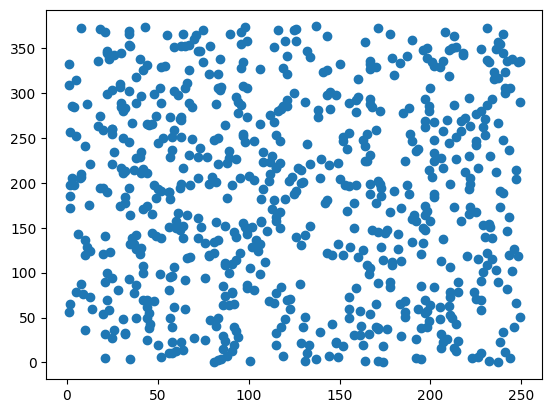

In [81]:
#Creamos el mapa y las escuelas
num_escuelas=709
diametro=250

escuelas_x = np.random.randint(0,diametro, num_escuelas)
escuelas_y = np.random.randint(0,1.5*diametro,num_escuelas)
escuelas=np.array([escuelas_x,escuelas_y]).T
plt.scatter(escuelas[:,0],escuelas[:,1])

Creamos el conjunto de empresas y sus ofertas, para las tres simulaciones.

Con esta información, creamos las unidades de competencia.

In [82]:
#Creamos un conjunto de empresas
#Creamos su conjunto de escuelas en las que oferta - para las 3 simulaciones

num_empresas=4 # Con 5 y 4 me exploto el kernel, sacando el alternativo

B1 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 
B2 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 
B3 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 

J1, sin_of, I_j ,J_i=extraer_clases_equivalencias(B1)  # sin_of = lista de escuelas donde nadie ofertó
J2, sin_of_2, I_j_2 ,J_i_2=extraer_clases_equivalencias(B2)
J3, sin_of_3, I_j_3 ,J_i_3=extraer_clases_equivalencias(B3)

In [83]:
B1 #escuelas x empresas

array([[1, 1, 1, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       ...,
       [1, 0, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

Decidimos los rangos de precios de las distintas empresas

In [84]:
T_min=list(range(0,100,20))+list(range(100,200,50))+list(range(200,701,100))
T_max= [T_min[i]-1 for i in range(1,len(T_min))]+[709]
costos=np.zeros([num_empresas,len(T_max)])

for i in range(num_empresas):
    costos[i,0]=np.random.rand()*1000 + 400
    for t in range(1,len(T_max)):
        descuento=1-(np.random.rand()/10)
        costos[i,t]= costos[i,t-1] * descuento
        

In [85]:
costos # vemos los costos definidos

array([[1139.17204831, 1039.50235814, 1017.70167836, 1010.61303786,
         969.30958514,  916.97683362,  865.27292836,  797.37253147,
         775.97706759,  775.62734186,  773.54317757,  729.85572743,
         694.2864079 ],
       [ 905.46636149,  836.41609878,  832.57591835,  758.89520829,
         753.90015301,  725.64398213,  699.53404673,  673.85883445,
         655.89315052,  638.53547404,  589.85577976,  558.57749359,
         551.82868344],
       [1366.90839876, 1329.71306927, 1247.32345301, 1137.80783582,
        1077.59122182, 1037.28863696, 1019.67042065, 1019.46269327,
         971.09540879,  919.83458276,  851.50094574,  813.92622467,
         795.26778402],
       [1140.65047806, 1124.89099391, 1017.0582367 ,  979.80128337,
         925.41863347,  837.90936768,  786.01198583,  772.33183745,
         695.88454198,  639.71871038,  599.74759475,  590.80442322,
         532.88922999]])

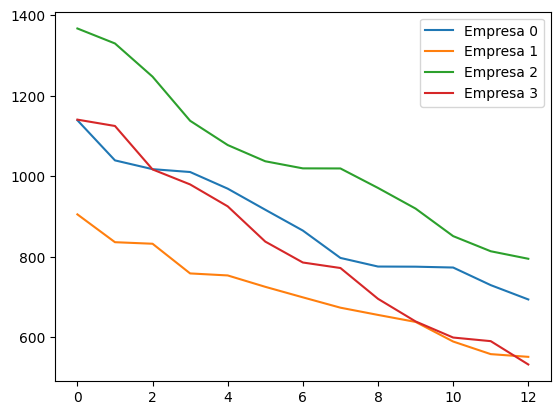

In [86]:
# comparamos los precios para las distintas empresas en distintos rangos
for i in range(num_empresas):
    plt.plot(range(0,len(T_max)),costos[i], label=f"Empresa {i}")
plt.legend()

## Solucionamos las simulaciones

### Caso 1:

In [87]:
## creamos el modelo
model, sin_ofertantes, _ = definir_modelo(B1,costos,nombre_modelo="Licitacion",T_max=T_max,T_min=T_min)

In [88]:
# obtenemos la solución
#model.redirectOutput()
model.optimize()
sol=model.getBestSol()
model.writeSol(sol,"solve1.xlsx")
valor_optimo=model.getObjVal()

In [89]:
modelo_alternativo, sin_ofertantes_alternativo = obtener_optimos_alternativos(B1,costos,model,sol,T_max=T_max,T_min=T_min)

Comparamos las soluciones

In [90]:
#modelo_alternativo.redirectOutput()
modelo_alternativo.optimize()
if round(modelo_alternativo.getObjVal(), 2) == round(valor_optimo, 2):
    sol_alternativa=modelo_alternativo.getBestSol()
    modelo_alternativo.writeSol(sol,"solve1_alt.xlsx")
else:
    print("No hay otra solución óptima.")

In [91]:
modelo_alternativo.getObjVal() , valor_optimo

(501974.22182897234, 501974.2218289723)

In [92]:
reparto=filtrar_variables_ganadores(model,sol)
print("Reparto de escuelas original")
print(reparto)

try:
    reparto_alt=filtrar_variables_ganadores(modelo_alternativo,sol_alternativa)
    print()
    print("Reparto de escuelas alternativo")
    print(reparto_alt)
except NameError:
    print("No hay solución alternativa")

Reparto de escuelas original
{(1, 14): 11.0, (0, 2): 47.0, (0, 5): 6.0, (2, 6): 37.0, (2, 9): 3.0, (0, 10): 47.0, (3, 1): 46.0, (3, 3): 46.0, (3, 7): 46.0, (3, 11): 58.0, (3, 12): 45.0, (3, 13): 27.0, (3, 14): 32.0, (1, 0): 52.0, (1, 4): 40.0, (1, 5): 37.0, (1, 8): 42.0, (1, 9): 43.0}

Reparto de escuelas alternativo
{(2, 6): 37.0, (0, 10): 47.0, (3, 1): 46.0, (3, 3): 46.0, (3, 7): 36.0, (3, 8): 42.0, (3, 11): 58.0, (3, 12): 45.0, (3, 13): 27.0, (1, 0): 52.0, (1, 4): 40.0, (1, 5): 34.0, (1, 7): 10.0, (1, 9): 46.0, (1, 14): 43.0, (0, 2): 44.0, (0, 5): 9.0, (2, 2): 3.0}


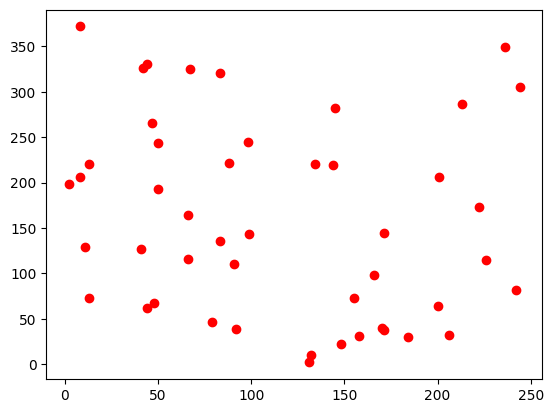

In [93]:
plot_UC(escuelas,J1,2,reparto) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

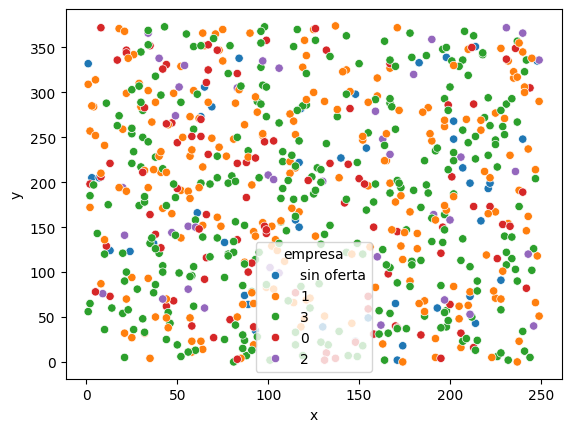

In [94]:
plot_reparto(escuelas, J1, reparto, sin_of) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

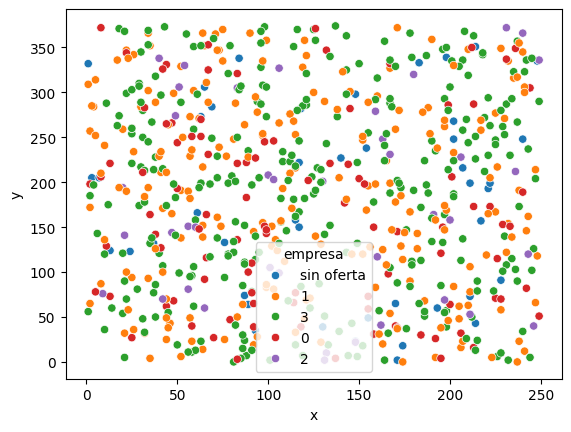

In [95]:
try:
    plot_reparto(escuelas, J1, reparto_alt, sin_of) 
except NameError:
    print("No hay una segunda mejor solución")

### Caso 2:

In [15]:
## creamos el modelo
model, sin_ofertantes, _ = definir_modelo(B2,costos,nombre_modelo="Licitacion 2",T_max=T_max,T_min=T_min)

In [16]:
# obtenemos la solución
#model.redirectOutput()
model.optimize()
sol=model.getBestSol()
model.writeSol(sol,"solve2.xlsx")
valor_optimo=model.getObjVal()

In [19]:
modelo_alternativo, sin_ofertantes_alternativo = obtener_optimos_alternativos(B1,costos,model,sol,T_max=T_max,T_min=T_min)

Comparamos las soluciones

In [20]:
modelo_alternativo.optimize()
if round(modelo_alternativo.getObjVal(), 2) == round(valor_optimo, 2):
    sol_alternativa=modelo_alternativo.getBestSol()
else:
    print("No hay otra solución óptima.")

No hay otra solución óptima.


In [21]:
modelo_alternativo.getObjVal() , valor_optimo

(454593.63291994657, 457701.9663836863)

In [22]:
reparto=filtrar_variables_ganadores(model,sol)
print(reparto)

try:
    reparto_alt=filtrar_variables_ganadores(modelo_alternativo,sol_alternativa)
    print()
    print(reparto_alt)
except NameError:
    print("No hay solución alternativa")

{(1, 11): 53.0, (1, 14): 44.0, (0, 13): 46.0, (0, 1): 40.0, (0, 2): 43.0, (0, 4): 46.0, (0, 5): 43.0, (2, 0): 45.0, (0, 8): 46.0, (0, 9): 34.0, (3, 3): 38.0, (3, 6): 40.0, (3, 7): 48.0, (3, 10): 60.0, (0, 12): 36.0, (1, 6): 3.0}
No hay solución alternativa


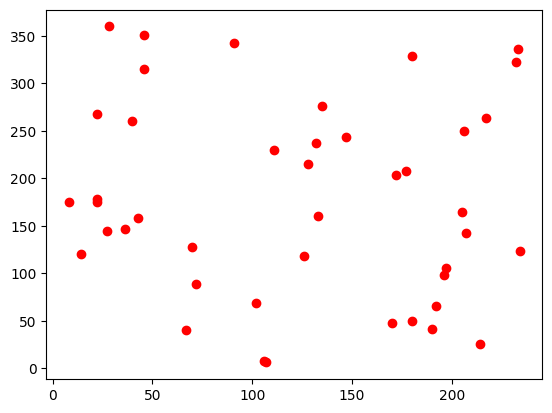

In [23]:
plot_UC(escuelas,J2,2,reparto) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

keys: [(2, 0)]
2 0 45.0
45
45
keys: [(0, 1)]
0 1 40.0
40
40
keys: [(0, 2)]
0 2 43.0
43
43
keys: [(3, 3)]
3 3 38.0
38
38
keys: [(0, 4)]
0 4 46.0
46
46
keys: [(0, 5)]
0 5 43.0
43
43
keys: [(3, 6), (1, 6)]
3 6 40.0
1 6 3.0
43
43
keys: [(3, 7)]
3 7 48.0
48
48
keys: [(0, 8)]
0 8 46.0
46
46
keys: [(0, 9)]
0 9 34.0
34
34
keys: [(3, 10)]
3 10 60.0
60
60
keys: [(1, 11)]
1 11 53.0
53
53
keys: [(0, 12)]
0 12 36.0
36
36
keys: [(0, 13)]
0 13 46.0
46
46
keys: [(1, 14)]
1 14 44.0
44
44


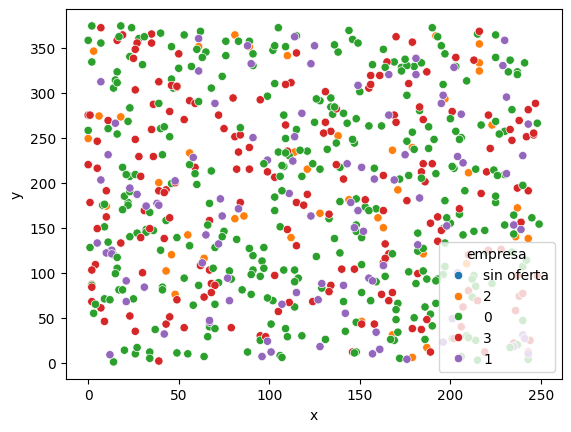

In [24]:
plot_reparto(escuelas, J2, reparto, sin_of) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

In [25]:
try:
    plot_reparto(escuelas, J2, reparto_alt, sin_of) 
except NameError:
    print("No hay una segunda mejor solución")

No hay una segunda mejor solución


### Caso 3:

In [26]:
## creamos el modelo
model, sin_ofertantes, _ = definir_modelo(B3,costos,nombre_modelo="Licitacion 3",T_max=T_max,T_min=T_min)

In [27]:
# obtenemos la solución
#model.redirectOutput()
model.optimize()
sol=model.getBestSol()
model.writeSol(sol,"solve3.xlsx")
valor_optimo=model.getObjVal()

In [29]:
modelo_alternativo, sin_ofertantes_alternativo = obtener_optimos_alternativos(B1,costos,model,sol,T_max=T_max,T_min=T_min)

Comparamos las soluciones

In [30]:
modelo_alternativo.optimize()
if round(modelo_alternativo.getObjVal(), 2) == round(valor_optimo, 2):
    sol_alternativa=modelo_alternativo.getBestSol()
else:
    print("No hay otra solución óptima.")

No hay otra solución óptima.


In [31]:
modelo_alternativo.getObjVal() , valor_optimo

(454593.63291994657, 455416.2735782559)

In [32]:
reparto=filtrar_variables_ganadores(model,sol)
print(reparto)

try:
    reparto_alt=filtrar_variables_ganadores(modelo_alternativo,sol_alternativa)
    print()
    print(reparto_alt)
except NameError:
    print("No hay solución alternativa")

{(1, 14): 41.0, (0, 0): 44.0, (0, 1): 48.0, (0, 2): 48.0, (2, 4): 3.0, (2, 12): 55.0, (2, 14): 2.0, (0, 6): 40.0, (0, 7): 46.0, (0, 8): 48.0, (0, 9): 44.0, (0, 10): 37.0, (3, 3): 32.0, (3, 4): 55.0, (3, 11): 42.0, (3, 13): 44.0, (1, 5): 39.0}
No hay solución alternativa


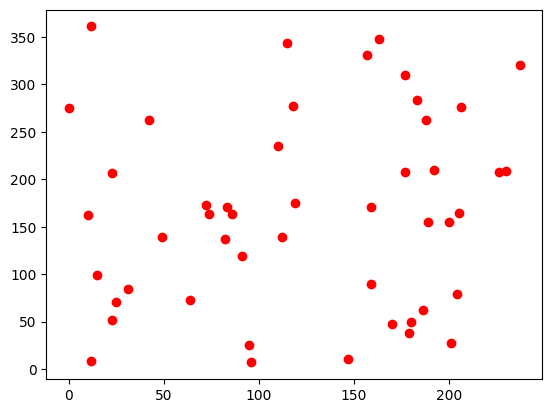

In [33]:
plot_UC(escuelas,J3,2,reparto) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

keys: [(0, 0)]
0 0 44.0
44
44
keys: [(0, 1)]
0 1 48.0
48
48
keys: [(0, 2)]
0 2 48.0
48
48
keys: [(3, 3)]
3 3 32.0
32
32
keys: [(2, 4), (3, 4)]
2 4 3.0
3 4 55.0
58
58
keys: [(1, 5)]
1 5 39.0
39
39
keys: [(0, 6)]
0 6 40.0
40
40
keys: [(0, 7)]
0 7 46.0
46
46
keys: [(0, 8)]
0 8 48.0
48
48
keys: [(0, 9)]
0 9 44.0
44
44
keys: [(0, 10)]
0 10 37.0
37
37
keys: [(3, 11)]
3 11 42.0
42
42
keys: [(2, 12)]
2 12 55.0
55
55
keys: [(3, 13)]
3 13 44.0
44
44
keys: [(1, 14), (2, 14)]
1 14 41.0
2 14 2.0
43
43


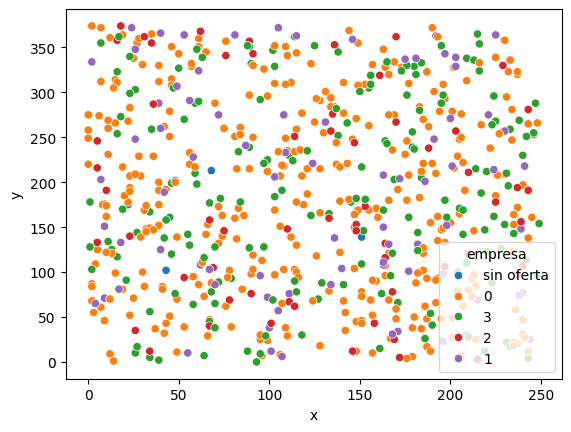

In [34]:
plot_reparto(escuelas, J3, reparto, sin_of) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

In [35]:
try:
    plot_reparto(escuelas, J1, reparto_alt, sin_of) 
except NameError:
    print("No hay una segunda mejor solución")

No hay una segunda mejor solución
